Here, I have predicted the sentiment score of the Title and the Headline of the news articles. 

The target columns are:
- `SentimentTitle`, which is the sentiment score of the Title
- `SentimentHeadline`, which is the sentiment score of the Headline

I have used Custom Transform pipelines with Multi-Output Regressor in `scikit-learn`

In [1]:
!pip install daal4py==2021.6.3

     |████████████████████████████████| 26.0 MB 218 kB/s eta 0:00:01
     |████████████████████████████████| 300.3 MB 13 kB/s  eta 0:00:011     |██████████████████▋             | 175.1 MB 448 kB/s eta 0:04:40     |█████████████████████           | 197.1 MB 453 kB/s eta 0:03:48     |████████████████████████▎       | 227.5 MB 139 kB/s eta 0:08:42��█████▋| 296.9 MB 423 kB/s eta 0:00:09
     |████████████████████████████████| 4.0 MB 58.2 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import nltk
# nltk.download('stopwords')
# print('Downloaded Stopwords')
from nltk.corpus import stopwords
import re
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors  import KNeighborsRegressor 
from sklearn.linear_model import LogisticRegression
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
stop_words = STOP_WORDS
import string
punctuations = string.punctuation
from sklearn.feature_extraction.text import HashingVectorizer

In [3]:
from daal4py.sklearn.ensemble import RandomForestRegressor as d4prdf
from daal4py.sklearn.neighbors  import KNeighborsRegressor as d4pknr 
from daal4py.sklearn.linear_model import LogisticRegression as d4plr
from daal4py.sklearn.model_selection import _daal_train_test_split as d4ptts
import time

In [4]:
# train = pd.read_csv('https://raw.githubusercontent.com/Ashish-Waykar/DSA/main/training_data_sentiment.csv ')
train = pd.read_csv('/kaggle/input/training-data-sentimentcsv/training_data_sentiment.csv')

In [5]:
train.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,02-04-2002 00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,20-09-2008 00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,28-01-2012 00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,01-03-2015 00:06,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,01-03-2015 00:11,-1,-1,-1,0.000000,0.141084


In [6]:
train.loc[0,'Headline']

'Obama Lays Wreath at Arlington National Cemetery. President Barack Obama has laid a wreath at the Tomb of the Unknowns to honor'

In [7]:
train.loc[0,'Title']

'Obama Lays Wreath at Arlington National Cemetery'

In [8]:
missing_val = pd.DataFrame(train.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,IDLink,0
1,Title,0
2,Headline,0
3,Source,118
4,Topic,0
5,PublishDate,0
6,Facebook,0
7,GooglePlus,0
8,LinkedIn,0
9,SentimentTitle,0


In [9]:
train[train['Source'].isna()]

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
6,lKg2pImhCl,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,28-02-2016 14:03,0,0,0,0.000000,-0.005906
56,ZOKue2cqfO,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,01-03-2016 09:29,0,0,0,0.000000,0.048546
111,JXfRvxs0R6,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,01-03-2016 00:15,0,0,0,-0.243068,0.048546
350,A1YOXDsuOO,Human rights situation in Palestinian territor...,In a special meeting convened by the UN Human ...,NaN,palestine,28-10-2015 17:24,-1,-1,-1,-0.228299,-0.124931
409,fO2mYsUg5P,Japan Contributes $5.73M To UNRWA’s Food Assis...,"JERUSALEM, October 31, 2015 (WAFA) – The Japan...",NaN,palestine,31-10-2015 04:30,-1,-1,-1,0.166667,-0.042878
...,...,...,...,...,...,...,...,...,...,...,...
39230,ZZmwDJou35,January Economy Watchers Survey:Current Trends...,The latest announced January Economy Watchers ...,NaN,economy,14-02-2016 19:26,0,0,0,0.000000,0.000000
39236,qyaKwqu5Qw,"Monday, 15 Feb 2016","NABLUS, February 14, 2016 (WAFA) – The 'Al-Qud...",NaN,palestine,14-02-2016 20:01,0,0,0,0.000000,-0.130558
39315,vzokT7n28T,"Monday, 15 Feb 2016","RAMALLAH, February 15, 2016 (WAFA) – At least ...",NaN,palestine,15-02-2016 02:01,0,0,0,0.000000,-0.197128
39521,G09yAhdz3Y,"Tuesday, 16 Feb 2016","RAMALLAH, February 15, 2016 (WAFA) – At least ...",NaN,palestine,15-02-2016 14:18,0,0,0,0.000000,-0.197128


In [10]:
train.dropna(inplace=True)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40390 entries, 0 to 40507
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             40390 non-null  object 
 1   Title              40390 non-null  object 
 2   Headline           40390 non-null  object 
 3   Source             40390 non-null  object 
 4   Topic              40390 non-null  object 
 5   PublishDate        40390 non-null  object 
 6   Facebook           40390 non-null  int64  
 7   GooglePlus         40390 non-null  int64  
 8   LinkedIn           40390 non-null  int64  
 9   SentimentTitle     40390 non-null  float64
 10  SentimentHeadline  40390 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 3.7+ MB


In [12]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Facebook,40390.0,143.091235,746.196820,-1.000000,0.000000,6.000000,39.000000,40836.000000
GooglePlus,40390.0,5.031542,22.623625,-1.000000,0.000000,0.000000,2.000000,1267.000000
LinkedIn,40390.0,14.055558,73.134803,-1.000000,0.000000,0.000000,4.000000,3652.000000
SentimentTitle,40390.0,-0.007379,0.135920,-0.838525,-0.079057,0.000000,0.062500,0.962354
SentimentHeadline,40390.0,-0.029209,0.142093,-0.755355,-0.116139,-0.027277,0.057948,0.900000


In [13]:
train['Topic'].value_counts()

economy      14965
obama        12015
microsoft     9459
palestine     3951
Name: Topic, dtype: int64

### EDA & Data Visualization

In [14]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['Palestinian','Palestine','Microsoft','Economy','Obama','Barack'])

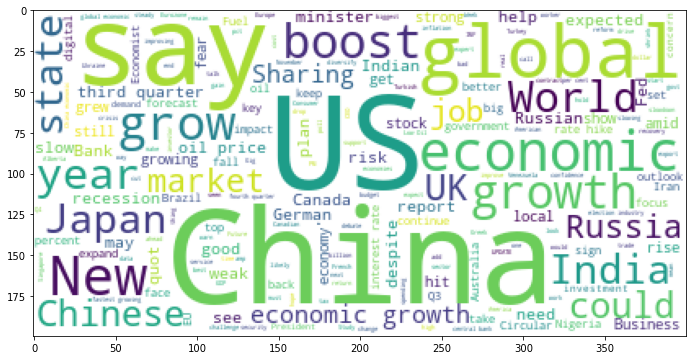

In [15]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.Title[train['Topic']=='economy'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

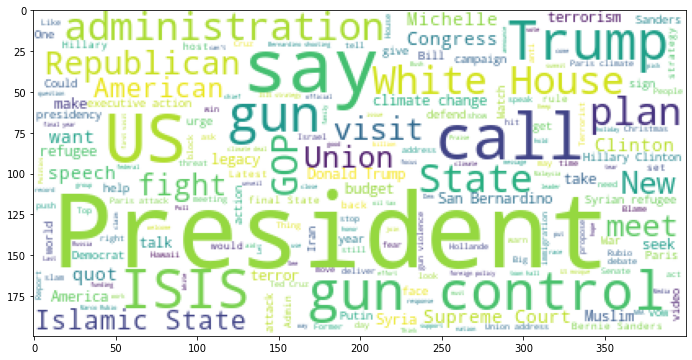

In [16]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.Title[train['Topic']=='obama'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

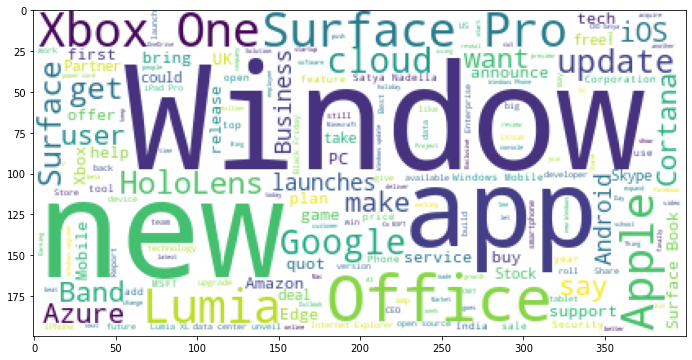

In [17]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.Title[train['Topic']=='microsoft'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

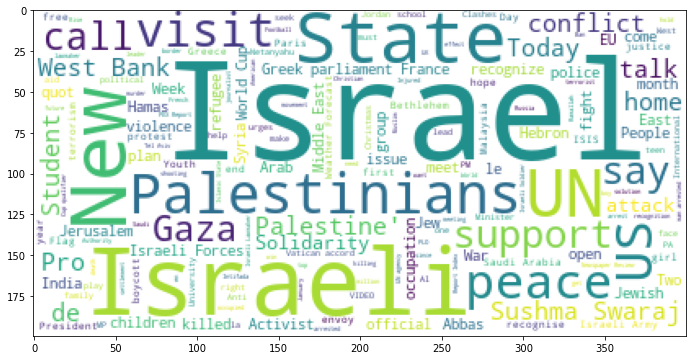

In [18]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.Title[train['Topic']=='palestine'])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

In [19]:
sns.set(style='darkgrid',palette='Set1')

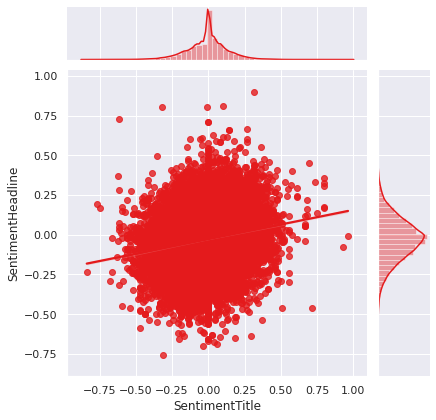

In [20]:
_ = sns.jointplot(x='SentimentTitle',y='SentimentHeadline',data=train,kind = 'reg')
plt.show()

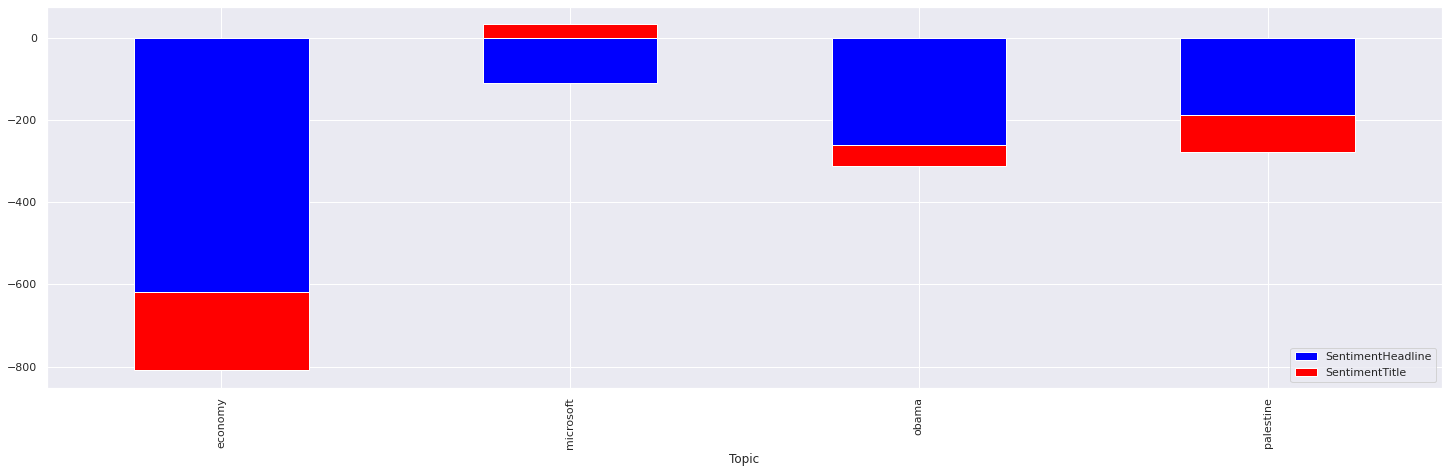

In [21]:

# Bar graph exploring total sentiment for the different topics

train.groupby('Topic').agg('sum')[['SentimentHeadline', 'SentimentTitle']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, color=['b', 'r', 'g']);

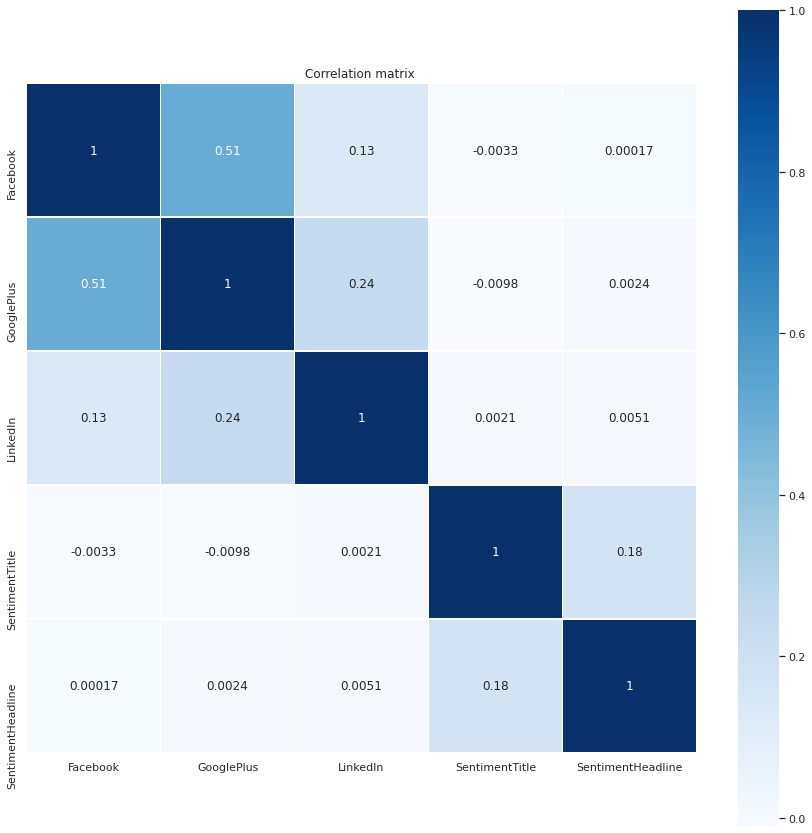

In [22]:
plt.figure(figsize=(15,15))
_ = sns.heatmap(train[['Facebook','GooglePlus','LinkedIn','SentimentTitle','SentimentHeadline']].corr(), square=True, cmap='Blues',linewidths=0.5,linecolor='w',annot=True)
plt.title('Correlation matrix ')

plt.show()

### Loading spacy English model

In [23]:
nlp = English()

### Custom Tokenizer Function

In [24]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # here the token is converted into lowercase if it is a Pronoun and if it is not a Pronoun then it is lemmatized and lowercased    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words using stopword from spacy library and punctuations from string library
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

### Custom Transformer and text cleaner 

In [25]:
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        
        return [clean_text(text) for text in X]

    def fit(self, X, y, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}


def clean_text(text):
   
    return text.strip().lower()

Converting words to word vectors

In [26]:
bow_vector = CountVectorizer(max_features = 100,tokenizer = spacy_tokenizer,ngram_range=(1,2))

Spearating Title and headline, so that they can be trained separately

In [27]:
X_train_title = train.loc[:,'Title'].values
y_train_title = train.loc[:,['SentimentTitle']].values

X_train_headline = train.loc[:,'Headline'].values
y_train_headline = train.loc[:,['SentimentHeadline']].values

In [28]:
X_train_title.shape

(40390,)

In [29]:
y_train_headline.shape

(40390, 1)

# Splitting both Title and Headline into training and testing sets

In [30]:
from sklearn.model_selection import train_test_split
# SKL train test split 
x_train_title, x_valid_title, Y_train_title, y_valid_title = train_test_split(X_train_title, y_train_title, shuffle = True, test_size = 0.15)
x_train_headline, x_valid_headline, Y_train_headline, y_valid_headline = train_test_split(X_train_headline, y_train_headline, shuffle = True, test_size = 0.15)

# d4p train test split 
x_train_title_d4p, x_valid_title_d4p, Y_train_title_d4p, y_valid_title_d4p = d4ptts(X_train_title, y_train_title, shuffle = True, test_size = 0.15)
x_train_headline_d4p, x_valid_headline_d4p, Y_train_headline_d4p, y_valid_headline_d4p = d4ptts(X_train_headline, y_train_headline, shuffle = True, test_size = 0.15)

# XGBoost and Random Forrest Regressor

In [31]:
xgboost = MultiOutputRegressor(XGBRegressor())
rand_for = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,max_depth=None,random_state=0))
rand_for_d4prfr = MultiOutputRegressor(d4prdf(n_estimators=100,max_depth=None,random_state=0))

In [32]:
knnr = MultiOutputRegressor(KNeighborsRegressor())
d4pknr = MultiOutputRegressor(d4pknr())


Defining separate pipelines for title and headline. You can choose which regressor you want to use. In this notebook I have used the Random Forrest Regressor

# ***Making pipelining Architecture***

In [39]:
# sikitlearn  KNeighbors forest
# Title
skl_pipe_title_knr = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', knnr)])
# Headline
skl_pipe_headline_knr = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', knnr)])

# daal4py  KNeighbors forest
# Title
d4p_pipe_title_knr = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', d4pknr)])
# headline
d4p_pipe_headline_knr = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', d4pknr)])

In [40]:
# daal4py Random forest
# title
skl_pipe_title_rdf = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', rand_for)])
# headline
skl_pipe_headline_rdf = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', rand_for)])


# daal4py Random forest
# title
d4p_pipe_title_rdf = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', rand_for_d4prfr)])
# headline
d4p_pipe_headline_rdf = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('tfidf',TfidfTransformer()),
                 ('regressor', rand_for_d4prfr)])

Train the Regressors for title and headline respectively

# ****Scikit Learn TRAIN TEST SPLIT****

In [45]:
# using train test split from SKL 
# SKLEARN title model fitting
skl_ttf_title_rfr=skl_pipe_title_rdf.fit(x_train_title,Y_train_title)
skl_ttf_title_knr=skl_pipe_title_knr.fit(x_train_title,Y_train_title)
# Daal4py title model fitting
d4p_ttf_title_rfr= d4p_pipe_title_rdf.fit(x_train_title,Y_train_title)
d4p_ttf_title_knr=d4p_pipe_title_knr.fit(x_train_title,Y_train_title)


In [46]:
# sklearn headline model fitting
skl_ttf_headline_rfr=skl_pipe_headline_rdf.fit(x_train_headline,Y_train_headline)
skl_ttf_headline_knr=skl_pipe_headline_knr.fit(x_train_headline,Y_train_headline)
# Daal4py headline model fitting
d4p_ttf_headline_rfr=d4p_pipe_headline_rdf.fit(x_train_headline_d4p,Y_train_headline_d4p)
d4p_ttf_headline_knr=d4p_pipe_headline_knr.fit(x_train_headline_d4p,Y_train_headline_d4p)

In [48]:
lst=[x_train_title[1],Y_train_title[1]]
print(lst)

['Chromebooks schooling Apple, Microsoft in education market ...', array([0.09449112])]


In [100]:
# x_valid_title predictions
skl_rfr_title_predictions=skl_ttf_title_rfr.predict(x_valid_title)
skl_rfr_d4p_title_predictions=d4p_ttf_title_rfr.predict(x_valid_title)
# x_valid_title predictions
skl_knr_title_predictions=skl_ttf_title_knr.predict(x_valid_title)
skl_knr_d4p_title_predictions=d4p_ttf_title_knr.predict(x_valid_title)



# x_valid_headline predictions
skl_ttf_headline_rfr_predictions=skl_ttf_headline_rfr.predict(x_valid_title)
skl_ttf_headline_knr_predictions=skl_ttf_headline_knr.predict(x_valid_title)
# x_valid_headline predictions
d4p_ttf_headline_rfr_predictions=d4p_ttf_headline_rfr.predict(x_valid_title)
d4p_ttf_headline_knr_predictions=d4p_ttf_headline_knr.predict(x_valid_title)





In [74]:
print(np.concatenate((skl_rfr_title.reshape(len(skl_rfr_title),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((skl_rfr_d4p_title.reshape(len(skl_rfr_d4p_title),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((skl_knr_title.reshape(len(skl_knr_title),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((skl_knr_d4p_title.reshape(len(skl_knr_d4p_title),1),y_valid_title.reshape(len(y_valid_title),1)),1))

[[ 0.00503042  0.        ]
 [-0.06859515  0.24705294]
 [-0.05761993  0.07905694]
 ...
 [-0.04231808  0.        ]
 [ 0.00913701  0.08838835]
 [ 0.0355916   0.        ]]
[[-0.0432931   0.        ]
 [-0.03903944  0.24705294]
 [-0.03104441  0.07905694]
 ...
 [-0.0115628   0.        ]
 [ 0.03676608  0.08838835]
 [ 0.1084636   0.        ]]
[[ 0.04682332  0.        ]
 [-0.13225377  0.24705294]
 [-0.0936237   0.07905694]
 ...
 [-0.01911908  0.        ]
 [-0.070693    0.08838835]
 [ 0.00812743  0.        ]]
[[-0.07702398  0.        ]
 [ 0.03897694  0.24705294]
 [ 0.04995887  0.07905694]
 ...
 [ 0.06370063  0.        ]
 [ 0.01237233  0.08838835]
 [ 0.09934749  0.        ]]


In [103]:
print(np.concatenate((skl_ttf_headline_rfr_predictions.reshape(len(skl_ttf_headline_rfr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((skl_ttf_headline_knr_predictions.reshape(len(skl_ttf_headline_knr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((d4p_ttf_headline_rfr_predictions.reshape(len(d4p_ttf_headline_rfr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((d4p_ttf_headline_knr_predictions.reshape(len(d4p_ttf_headline_knr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))

[[ 0.0176628   0.        ]
 [-0.03903944  0.24705294]
 [-0.03104441  0.07905694]
 ...
 [-0.0115628   0.        ]
 [-0.00381599  0.08838835]
 [-0.05743419  0.        ]]
[[ 0.05979507  0.        ]
 [ 0.03897694  0.24705294]
 [ 0.04995887  0.07905694]
 ...
 [ 0.06370063  0.        ]
 [ 0.04446422  0.08838835]
 [-0.05656881  0.        ]]
[[ 0.0176628   0.        ]
 [-0.03903944  0.24705294]
 [-0.03104441  0.07905694]
 ...
 [-0.0115628   0.        ]
 [-0.00381599  0.08838835]
 [-0.05743419  0.        ]]
[[ 0.05979507  0.        ]
 [ 0.03897694  0.24705294]
 [ 0.04995887  0.07905694]
 ...
 [ 0.06370063  0.        ]
 [ 0.04446422  0.08838835]
 [-0.05656881  0.        ]]


In [72]:
# skl_rfr_title + y_valid_title
print(y_valid_title.shape)
print(skl_rfr_title.shape)

(6059, 1)
(6059, 1)


### Predicting sentiment titals

In [76]:
# x_valid_title
skl_rfr_title=skl_ttf_title_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_rfr_title)
skl_rfr_d4p_title=d4p_ttf_title_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_rfr_d4p_title)

# x_valid_title
skl_knr_title=skl_ttf_title_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_knr_title)
skl_knr_d4p_title=d4p_ttf_title_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_knr_d4p_title)

[[-0.02714634]]
[[0.04020256]]
[[0.0029438]]
[[-0.04847433]]


### Predicting Sentiment Headline

In [79]:
# x_valid_Headline
skl_rfr_title=skl_ttf_headline_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_rfr_title)
skl_rfr_d4p_title=skl_ttf_headline_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_rfr_d4p_title)

# x_valid_Headline
skl_knr_title=d4p_ttf_headline_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_knr_title)
skl_knr_d4p_title=d4p_ttf_headline_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_knr_d4p_title)

[[0.05606235]]
[[0.01346592]]
[[-0.00319631]]
[[0.10731895]]


In [85]:
# here Code Starts For prediction And Other things 





# ***DAAL4PY TRAIN TEST SPLIT***

In [91]:
# using train test split from D4P
# SKLEARN title model fitting
skl_ttf_d4p_title_rfr=skl_pipe_title_rdf.fit(x_train_title_d4p,Y_train_title_d4p)
skl_ttf_d4p_title_knr=skl_pipe_title_knr.fit(x_train_title_d4p,Y_train_title_d4p)
# Daal4py title model fitting 
d4p_ttf_d4p_title_rfr=d4p_pipe_title_rdf.fit(x_train_title_d4p,Y_train_title_d4p)
d4p_ttf_d4p_title_knr=d4p_pipe_title_knr.fit(x_train_title_d4p,Y_train_title_d4p)


In [94]:
# sklearn headline model fitting
skl_ttf_d4p_headline_rfr=skl_pipe_headline_rdf.fit(x_train_headline_d4p,Y_train_headline_d4p)
skl_ttf_d4p_headline_knr=skl_pipe_headline_knr.fit(x_train_headline_d4p,Y_train_headline_d4p)
# Daal4py headline model fitting
d4p_ttf_d4p_headline_rfr=d4p_pipe_headline_rdf.fit(x_train_headline_d4p,Y_train_headline_d4p)
d4p_ttf_d4p_headline_knr=d4p_pipe_headline_knr.fit(x_train_headline_d4p,Y_train_headline_d4p)

In [102]:
# x_valid_title predictions
skl_ttf_d4p_title_rfr_predictions=skl_ttf_d4p_title_rfr.predict(x_valid_title)
skl_ttf_d4p_title_knr_predictions=skl_ttf_d4p_title_knr.predict(x_valid_title)
# x_valid_title predictions
d4p_ttf_d4p_title_rfr_predictions=d4p_ttf_d4p_title_rfr.predict(x_valid_title)
d4p_ttf_d4p_title_knr_predictions=d4p_ttf_d4p_title_knr.predict(x_valid_title)



# x_valid_headline predictions
skl_ttf_d4p_headline_rfr_predictions=skl_ttf_d4p_headline_rfr.predict(x_valid_title)
skl_ttf_d4p_headline_knr_predictions=skl_ttf_d4p_headline_knr.predict(x_valid_title)
# x_valid_headline predictions
d4p_ttf_d4p_headline_rfr_predictions=d4p_ttf_d4p_headline_rfr.predict(x_valid_title)
d4p_ttf_d4p_headline_knr_predictions=d4p_ttf_d4p_headline_knr.predict(x_valid_title)

In [105]:
print(np.concatenate((skl_ttf_d4p_title_rfr_predictions.reshape(len(skl_ttf_d4p_title_rfr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((skl_ttf_d4p_title_knr_predictions.reshape(len(skl_ttf_d4p_title_knr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((d4p_ttf_d4p_title_rfr_predictions.reshape(len(d4p_ttf_d4p_title_rfr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((d4p_ttf_d4p_title_knr_predictions.reshape(len(d4p_ttf_d4p_title_knr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))

[[-0.04077936  0.        ]
 [-0.03903944  0.24705294]
 [-0.03104441  0.07905694]
 ...
 [-0.0115628   0.        ]
 [ 0.04586471  0.08838835]
 [ 0.06315147  0.        ]]
[[-0.01238058  0.        ]
 [ 0.03897694  0.24705294]
 [ 0.04995887  0.07905694]
 ...
 [ 0.06370063  0.        ]
 [-0.05517527  0.08838835]
 [ 0.00135645  0.        ]]
[[-0.04077936  0.        ]
 [-0.03903944  0.24705294]
 [-0.03104441  0.07905694]
 ...
 [-0.0115628   0.        ]
 [ 0.04586471  0.08838835]
 [ 0.06315147  0.        ]]
[[-0.01238058  0.        ]
 [ 0.03897694  0.24705294]
 [ 0.04995887  0.07905694]
 ...
 [ 0.06370063  0.        ]
 [-0.05517527  0.08838835]
 [ 0.00135645  0.        ]]


In [104]:
print(np.concatenate((skl_ttf_d4p_headline_rfr_predictions.reshape(len(skl_ttf_d4p_headline_rfr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((skl_ttf_d4p_headline_knr_predictions.reshape(len(skl_ttf_d4p_headline_knr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((d4p_ttf_d4p_headline_rfr_predictions.reshape(len(d4p_ttf_d4p_headline_rfr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))
print(np.concatenate((d4p_ttf_d4p_headline_knr_predictions.reshape(len(d4p_ttf_d4p_headline_knr_predictions),1),y_valid_title.reshape(len(y_valid_title),1)),1))

[[ 0.0176628   0.        ]
 [-0.03903944  0.24705294]
 [-0.03104441  0.07905694]
 ...
 [-0.0115628   0.        ]
 [-0.00381599  0.08838835]
 [-0.05743419  0.        ]]
[[ 0.05979507  0.        ]
 [ 0.03897694  0.24705294]
 [ 0.04995887  0.07905694]
 ...
 [ 0.06370063  0.        ]
 [ 0.04446422  0.08838835]
 [-0.05656881  0.        ]]
[[ 0.0176628   0.        ]
 [-0.03903944  0.24705294]
 [-0.03104441  0.07905694]
 ...
 [-0.0115628   0.        ]
 [-0.00381599  0.08838835]
 [-0.05743419  0.        ]]
[[ 0.05979507  0.        ]
 [ 0.03897694  0.24705294]
 [ 0.04995887  0.07905694]
 ...
 [ 0.06370063  0.        ]
 [ 0.04446422  0.08838835]
 [-0.05656881  0.        ]]


### Predicting Sentiment Titals

In [97]:
# x_valid_title
skl_ttf_d4p_title_rfr_predict=skl_ttf_d4p_title_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_ttf_d4p_title_rfr_predict)
skl_ttf_d4p_title_knr_predict=skl_ttf_d4p_title_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_ttf_d4p_title_knr_predict)

# x_valid_title
d4p_ttf_d4p_title_rfr_predict=d4p_ttf_d4p_title_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(d4p_ttf_d4p_title_rfr_predict)
d4p_ttf_d4p_title_knr_predict=d4p_ttf_d4p_title_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(d4p_ttf_d4p_title_knr_predict)

[[0.04020256]]
[[0.04629384]]
[[0.04020256]]
[[0.04629384]]


### Predicting Sentiment Headlines

In [98]:
# x_valid_headline
skl_ttf_d4p_headline_rfr_predict=skl_ttf_d4p_headline_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_ttf_d4p_headline_rfr_predict)
skl_ttf_d4p_headline_knr_predict=skl_ttf_d4p_headline_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(skl_ttf_d4p_headline_knr_predict)

# x_valid_headline
d4p_ttf_d4p_headline_rfr_predict=d4p_ttf_d4p_headline_rfr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(d4p_ttf_d4p_headline_rfr_predict)
d4p_ttf_d4p_headline_knr_predict=d4p_ttf_d4p_headline_knr.predict(['Chromebooks schooling Apple, Microsoft in education market ...'])
print(d4p_ttf_d4p_headline_knr_predict)

[[-0.0546036]]
[[-0.06486945]]
[[-0.0546036]]
[[-0.06486945]]


In [ ]:
# here Code Starts For prediction And Other things 

Now we shall predict on the validation sets and then see what score we obtain

We achieved a score of 89.9. That is pretty good. This score is an indication of how close our predicted values were to the target values. It cannot exacly be termed as `accurcacy`, because this is not a classification problem. Our sentiment score is a real number between -1 and 1